# Pandas + ML — Part 6

**Goal:** Add cross-validation and a learning curve to assess model stability and bias/variance.

**What we do:**
- Ensure cleaned dataset exists
- 5-fold cross-validation for LogisticRegression, RandomForest, GradientBoosting
- Compute Accuracy and Macro-F1 (mean ± std)
- Plot a learning curve for RandomForest


In [6]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

CLEAN_PATH = "ml_projects/data/iris_cleaned_engineered.csv"

# Ensure cleaned dataset exists (create minimal version if missing)
if not os.path.exists(CLEAN_PATH):
    iris = load_iris(as_frame=True)
    df = iris.frame.copy()
    df.rename(columns={'target': 'species_index'}, inplace=True)
    df['species'] = df['species_index'].map(dict(enumerate(iris.target_names)))
    # Basic features + scaling
    df['sepal_area'] = df['sepal length (cm)'] * df['sepal width (cm)']
    df['petal_area'] = df['petal length (cm)'] * df['petal width (cm)']
    num_cols = [c for c in df.columns if df[c].dtype != 'object' and c != 'species_index']
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    os.makedirs("ml_projects/data", exist_ok=True)
    df.to_csv(CLEAN_PATH, index=False)
    print("Created:", CLEAN_PATH)
else:
    print("Found:", CLEAN_PATH)

df = pd.read_csv(CLEAN_PATH)
X = df.drop(columns=['species','species_index'])
y = df['species']

X.shape, y.value_counts()[:3]

Found: ml_projects/data/iris_cleaned_engineered.csv


((150, 6),
 species
 setosa        50
 versicolor    50
 virginica     50
 Name: count, dtype: int64)

## 5-fold Cross-Validation (Accuracy & Macro-F1)
We evaluate three models with stratified 5-fold CV.

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogReg": LogisticRegression(max_iter=200),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42)
}

rows = []
for name, mdl in models.items():
    acc = cross_val_score(mdl, X, y, cv=cv, scoring='accuracy')
    f1m = cross_val_score(mdl, X, y, cv=cv, scoring='f1_macro')
    rows.append((name, acc.mean(), acc.std(), f1m.mean(), f1m.std()))

cv_df = pd.DataFrame(rows, columns=["model","acc_mean","acc_std","f1_mean","f1_std"]).set_index("model")
cv_df

,acc_mean,acc_std,f1_mean,f1_std
model,,,,
LogReg,0.953333,0.045216,0.953216,0.045329
RandomForest,0.960000,0.038873,0.959798,0.039040
GradBoost,0.953333,0.033993,0.952840,0.034707


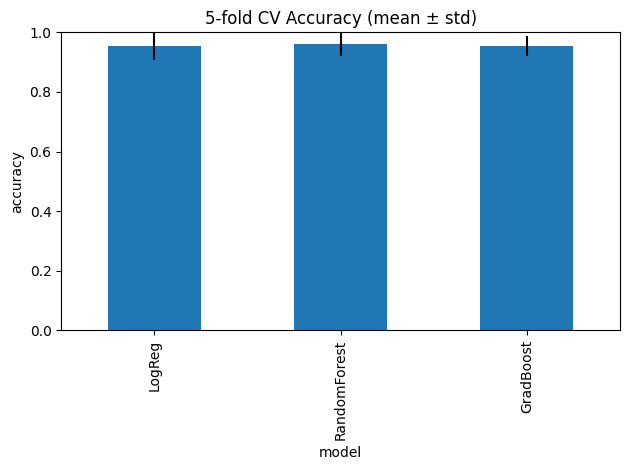

In [8]:
# Plot: Cross-validated Accuracy
plt.figure()
cv_df['acc_mean'].plot(kind='bar', yerr=cv_df['acc_std'])
plt.title('5-fold CV Accuracy (mean ± std)')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


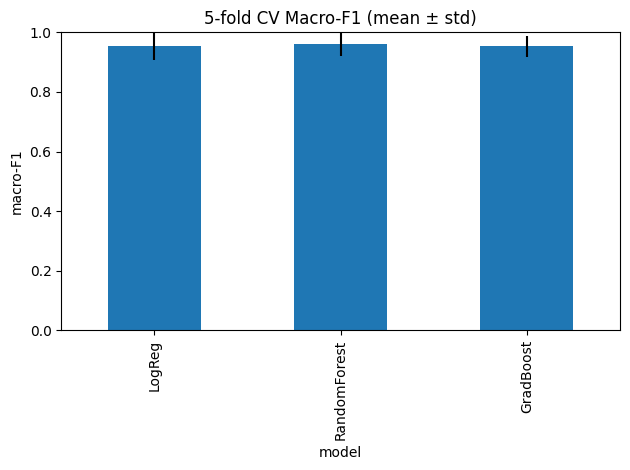

In [9]:
# Plot: Cross-validated Macro-F1
plt.figure()
cv_df['f1_mean'].plot(kind='bar', yerr=cv_df['f1_std'])
plt.title('5-fold CV Macro-F1 (mean ± std)')
plt.ylabel('macro-F1')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## Learning Curve (RandomForest)
Visualize how performance changes as we increase the training set size.

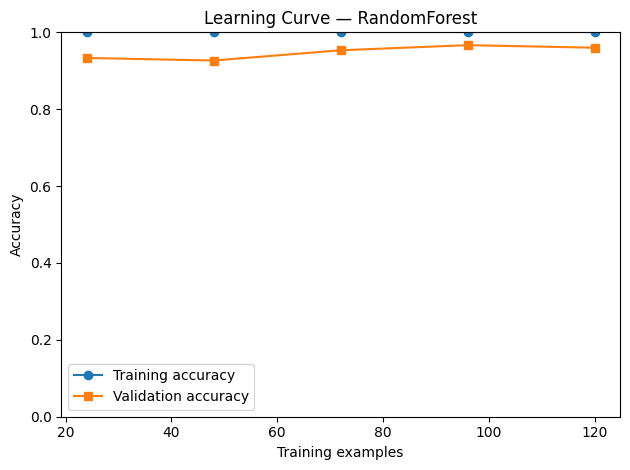

In [10]:
from sklearn.model_selection import learning_curve

rf = RandomForestClassifier(random_state=42)
train_sizes, train_scores, valid_scores = learning_curve(
    rf, X, y,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.2, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Training accuracy')
plt.plot(train_sizes, valid_mean, marker='s', label='Validation accuracy')
plt.title('Learning Curve — RandomForest')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()
